In [91]:
from util import load_model
from lp_detection import lp_detect
from align_lp import align_lp
from lp_recognition import lp_recognition
import cv2
import torch
from ultralytics import YOLO
import onnx
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune
import warnings
import copy
import os
import torch.nn as nn
import torch_pruning as tp
warnings.filterwarnings("ignore")

In [49]:
yolov8s = load_model("model/best_lp_detect.pt")
yolov8s_pruning = copy.deepcopy(yolov8s)
# corner_detect_model = load_model("model/best_corner_detect.pt").cpu()
# lp_recognition_model = load_model("model/best_lp_recognition.pt").cpu()

In [50]:
dumpy_input = np.random.rand(1, 3, 640, 640)
dumpy_input_onnx = np.random.rand(640, 640, 3)

In [52]:
out = yolov8s(torch.from_numpy(dumpy_input), verbose=False)

In [55]:
%%timeit
out = yolov8s(torch.from_numpy(dumpy_input), verbose=False)

19.7 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# ONNX

In [13]:
#export model
yolov8s.export(format="onnx")

Ultralytics YOLOv8.0.239 🚀 Python-3.9.18 torch-1.9.0+cu111 CPU (Intel Xeon E5-2683 v3 2.00GHz)

PyTorch: starting from 'model/best_lp_detect.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.15.0 opset 12...
ONNX: export success ✅ 2.5s, saved as 'model/best_lp_detect.onnx' (42.6 MB)

Export complete (4.2s)
Results saved to /home/bdi/Mammo_FDA/TensorRT/LP_recognition/model
Predict:         yolo predict task=detect model=model/best_lp_detect.onnx imgsz=640  
Validate:        yolo val task=detect model=model/best_lp_detect.onnx imgsz=640 data=/kaggle/working/coco128.yaml  
Visualize:       https://netron.app


'model/best_lp_detect.onnx'

In [14]:
import onnx

onnx_model = onnx.load("model/best_lp_detect.onnx")
onnx.checker.check_model(onnx_model)

In [28]:
import onnxruntime
import numpy as np 
import cv2


img = cv2.cvtColor(cv2.imread("/home/bdi/Mammo_FDA/TensorRT/LP_recognition/example/0046_01762_b.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 640)).astype(np.float16)
dumpy_input_numpy = np.expand_dims(img.transpose(2, 0, 1), axis=0)
print(dumpy_input_numpy.shape)

ort_session = onnxruntime.InferenceSession("model/best_lp_detect.onnx", providers=['CUDAExecutionProvider'])
#compute output onnx runtime
ort_input = {ort_session.get_inputs()[0].name: dumpy_input_numpy}
out = ort_session.run(None, ort_input)

(1, 3, 640, 640)


In [29]:
%%timeit
out = ort_session.run(None, ort_input)

150 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# TensorRT

In [23]:
yolov8s.export(format="engine", half=True, device=0)

Ultralytics YOLOv8.0.239 🚀 Python-3.9.18 torch-1.9.0+cu111 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11010MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'model/best_lp_detect.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.15.0 opset 12...
ONNX: export success ✅ 2.4s, saved as 'model/best_lp_detect.onnx' (21.3 MB)

TensorRT: starting export with TensorRT 8.4.3.1...
[01/30/2024-14:50:41] [TRT] [I] The logger passed into createInferBuilder differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[01/30/2024-14:50:41] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 5547, GPU 1900 (MiB)
[01/30/2024-14:50:42] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +273, GPU +68, now: CPU 5820, GPU 1968 (MiB)
[01/30/2024-14:50:4

'model/best_lp_detect.engine'

In [30]:
yolo_tensort = YOLO("model/best_lp_detect.engine", task="detect")

In [32]:
%%timeit
out = yolo_tensort(torch.from_numpy(dumpy_input), verbose=False)

5.96 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# TFlite

In [52]:
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/best_lp_detect_saved_model/best_lp_detect_int8.tflite")
# interpreter = tf.lite.Interpreter(model_path='best_float32.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image = cv2.imread("/home/bdi/Mammo_FDA/TensorRT/LP_recognition/example/0046_01762_b.jpg")
image = cv2.resize(image, (640,640))
# cv2_imshow(image)

image = np.array(image).astype('float32') / 255.0

# Set input tensor
input_shape = input_details[0]['shape']
input_data = np.array(image.reshape(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# # Get the output tensor values
output_data1 = interpreter.get_tensor(output_details[0]['index']) 

output_tensor = output_data1.reshape(8400,5)  # Reshape the tensor based on the output shape

H = image.shape[0]
W = image.shape[1]
for i in range(len(output_tensor)): 
    xPos,yPos,w,h=output_tensor[i][0:4]
    scores=output_tensor[i][4:5]
    if scores>0 and scores<1:
        xmin = int(max(1, xPos - w / 2)) 
        ymin = int(max(1, yPos - h / 2)) 
        xmax = int(min(H, xPos + w / 2))
        ymax = int(min(W,yPos + h / 2)) 
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0, 255, 0), 2)

In [57]:
yolov8_quan = YOLO("/home/bdi/Mammo_FDA/TensorRT/LP_recognition/model/best_lp_detect_saved_model/best_lp_detect_full_integer_quant.tflite")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [80]:
results = yolov8_quan("/home/bdi/Mammo_FDA/TensorRT/LP_recognition/example/0046_01762_b.jpg",  verbose=False)

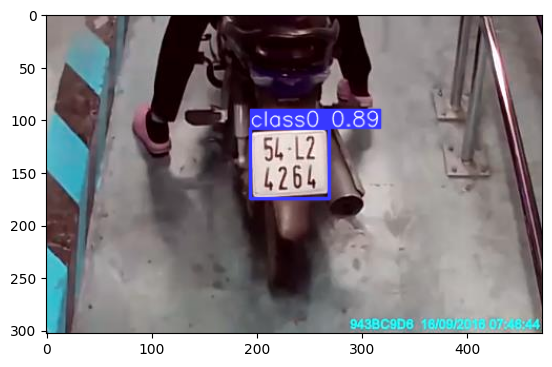

In [89]:
plt.imshow(results[0].plot())

# Purning model

In [113]:
len(torch.where(torch.rand(50).abs()>=0.5)[0])

24

In [117]:
from ultralytics import YOLO
import torch
from ultralytics.nn.modules import Bottleneck,Conv,C2f,SPPF,Detect
from torch import nn


def prune_conv(conv1:Conv,conv2:Conv):
    # thinking the sentivity of bn, min(gama) whether nearly equal to zer0
    # torch.sort(gamma,descending=True)[0].min()
    gamma = conv1.bn.weight.data.detach() # channel wise
    beta  = conv1.bn.bias.data.detach()
    
    # 
    keep_idx = []
    local_threshold = threshold
    
    while len(keep_idx) < 8:
        keep_idx = torch.where(gamma.abs()>=local_threshold)[0]
        local_threshold = local_threshold * 0.5
    n = len(keep_idx)
    # how much channels we keep
    # print("number of channels we keep:", n/len(gamma)*100, "%")
    # prune bn
    conv1.bn.weight.data = gamma[keep_idx]
    conv1.bn.bias.data   = beta[keep_idx]
    conv1.bn.running_var.data = conv1.bn.running_var.data[keep_idx]
    conv1.bn.running_mean = conv1.bn.running_mean.data[keep_idx]
    conv1.bn.num_features = n
    # prune conv channel
    conv1.conv.weight.data = conv1.conv.weight.data[keep_idx]
    conv1.conv.out_channels = n
    if conv1.conv.bias is not None:
        conv1.conv.bias.data = conv1.conv.bias.data[keep_idx]
    
    print(conv1.conv.weight.data.shape)
    # prune conv2
    if not isinstance(conv2,list):
        conv2 = [conv2]
    
    for item in conv2:
        if item is not None:
            if isinstance(item,Conv):
                conv = item.conv
            else:
                # Conv2d 
                conv = item
            
            conv.in_channels = n
            conv.weight.data = conv.weight.data[:,keep_idx]       
            
def prune(m1,m2):
    if isinstance(m1,C2f):
        m1 = m1.cv2
    if not isinstance(m2,list):
        m2 = [m2]
    for i,item in enumerate(m2):
        if isinstance(item,C2f) or isinstance(item,SPPF):
            m2[i] = item.cv1
    prune_conv(m1,m2)       
                

if __name__ == "__main__":
    yolo = YOLO("model/best_lp_detect.pt")
    model = yolo.model

    ws = []
    bs = []
    
    for k,m in model.named_modules():
        if isinstance(m,nn.BatchNorm2d):
            # m.weight meas gamma
            w = m.weight.abs().detach() 
            b = m.bias.abs().detach()
            ws.append(w)        
            bs.append(b)
            # print(k,w.max().item(),w.min().item(),b.max().item(),b.min().item())
            # print(w.min().item())

    factor = 0.99
    
    ws = torch.cat(ws)
    threshold = torch.sort(ws,descending=True)[0][int(len(ws)*factor)]
    print("threshold for pruning:",threshold)    

    # global pruning for Bottleneck
    for name,m in model.named_modules():
        if isinstance(m,Bottleneck):
            prune_conv(m.cv1,m.cv2)
    seq = model.model
    
    for i in range(3,9):
        if i in [4,6,9]: continue
        prune(seq[i],seq[i+1])
    
    detect:Detect = seq[-1]
    last_inputs = [seq[15],seq[18],seq[21]]
    colasts = [seq[16],seq[19],None]
    
    for last_input,colast,cv2,cv3 in zip(last_inputs,colasts,detect.cv2,detect.cv3):
        prune(last_input,[colast,cv2[0],cv3[0]])
        prune(cv2[0], cv2[1])
        prune(cv2[1], cv2[2])
        prune(cv3[0], cv3[1])
        prune(cv3[1], cv3[2])
        
    
    for name, p in yolo.model.named_parameters():
        p.requires_grad = True
        
    # yolo.val()
    # yolo.export(format='onnx')

threshold for pruning: tensor(0.3650)
number of channels we keep: 100.0 %
torch.Size([32, 32, 3, 3])
number of channels we keep: 95.3125 %
torch.Size([61, 64, 3, 3])
number of channels we keep: 98.4375 %
torch.Size([63, 64, 3, 3])
number of channels we keep: 100.0 %
torch.Size([128, 128, 3, 3])
number of channels we keep: 100.0 %
torch.Size([128, 128, 3, 3])
number of channels we keep: 99.609375 %
torch.Size([255, 256, 3, 3])
number of channels we keep: 100.0 %
torch.Size([128, 128, 3, 3])
number of channels we keep: 96.875 %
torch.Size([62, 64, 3, 3])
number of channels we keep: 98.4375 %
torch.Size([126, 128, 3, 3])
number of channels we keep: 100.0 %
torch.Size([256, 256, 3, 3])
number of channels we keep: 99.21875 %
torch.Size([127, 64, 3, 3])
number of channels we keep: 100.0 %
torch.Size([256, 128, 3, 3])
number of channels we keep: 100.0 %
torch.Size([512, 256, 3, 3])
number of channels we keep: 100.0 %
torch.Size([512, 768, 1, 1])
number of channels we keep: 69.53125 %
torch.Si

In [76]:
%%timeit
out = yolo(torch.from_numpy(dumpy_input), verbose=False)

19.5 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e+6)
    os.remove('temp.p')

In [89]:
print_size_of_model(yolov8s)

Size (MB): 44.554243


In [90]:
print_size_of_model(yolo)

Size (MB): 43.946179
